# Torch Connector and Hybrid QNNs

## Overview

This tutorial introduces Qiskit's `TorchConnector` [class](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.connectors.TorchConnector.html) and demonstrates how the `TorchConnector` allows for a natural integration of any `NeuralNetwork` from `qiskit-machine-learning` into a `PyTorch` workflow.

This tutorial is structured as follows:

[Part 1: Simple Classification & Regression](#Part-1:-Simple-Classification-&-Regression): The first part of this tutorial shows how quantum neural networks can be trained using PyTorch's automatic differentiation engine [torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html) for simple classification and regression tasks. 

1. [Classification](#1.-Classification)
    1. Classification with PyTorch and `EstimatorQNN`
    2. Classification with PyTorch and `SamplerQNN`
2. [Regression](#2.-Regression)
    1. Regression with PyTorch and `SamplerQNN`

[Part 2: MNIST Classification, Hybrid QNNs](#Part-2:-MNIST-Classification,-Hybrid-QNNs): The second part of this tutorial illustrates how to embed a (Quantum) `NeuralNetwork` into a target PyTorch workflow (in this case, a typical CNN architecture) to classify MNIST data in a hybrid quantum-classical manner.

## 1. Introduction

`TorchConnector` takes a Qiskit `NeuralNetwork` and makes it available as a PyTorch `Module`. The resulting module can be seamlessly incorporated into PyTorch classical architectures and trained jointly without additional considerations, enabling the development and testing of novel **hybrid quantum-classical** machine learning architectures. This is helpful in building quantum machine learning models upon already existing classical model frameworks being greatly used in the real world. Now let's get hands on!

We begin by setting up some utilities like fixing the algorithmic seed to ensure that the results don't change between runs.

In [1]:
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 42

## Part 1: Simple Classification & Regression

## 1. Classification

First, we show how `TorchConnector` allows to train a Quantum `NeuralNetwork` to solve a classification task using PyTorch's automatic differentiation engine. In order to illustrate this, we will perform **binary classification** on a randomly generated dataset.

### 1.1. Preparing the dataset
We generate a binary classification dataset with 2 features (or attributes) and 20 instances. We generate the 2 attributes with random values for the 20 instances and assign these values to X variable. For generating the binary labels corresponding to the instances we calculate y01 which can be either 0 or 1. Further, we map y01 to y where y can be either -1 or 1. 

Note: y01 will be used with `SamplerQNN` and y will be used with `EstimatorQNN` later on in the tutorial.

In [2]:
import numpy as np

num_inputs = 2
num_samples = 20

X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  
y = 2 * y01 - 1  

Let's have a look at 5 instance to understand the dataset better.

In [3]:
for i in range(5):
    print("Instance {}: X = {}  | y01 = {} | y = {}".format(i,X[i],y01[i],y[i])) 

Instance 0: X = [ 0.5479121  -0.12224312]  | y01 = 1 | y = 1
Instance 1: X = [0.71719584 0.39473606]  | y01 = 1 | y = 1
Instance 2: X = [-0.8116453  0.9512447]  | y01 = 1 | y = 1
Instance 3: X = [0.5222794  0.57212861]  | y01 = 1 | y = 1
Instance 4: X = [-0.74377273 -0.09922812]  | y01 = 0 | y = -1


Now we convert X, y01 and y to torch Tensors.

In [4]:
from torch import Tensor

X_ = Tensor(X)
y01_ = Tensor(y01).reshape(len(y)).long()
y_ = Tensor(y).reshape(len(y), 1)
X_[0], y01_[0], y_[0]

(tensor([ 0.5479, -0.1222]), tensor(1), tensor([1.]))

Let's visualize the dataset graphically.

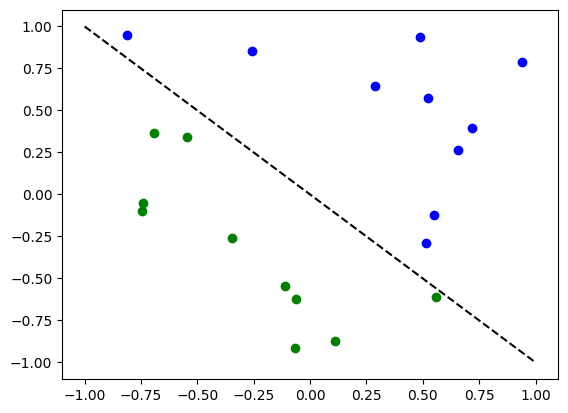

In [5]:
import matplotlib.pyplot as plt

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In this plot,
* The <span style="color: green;">green</span> points denote Class -1
* The <span style="color: blue;">blue</span> points denote Class 1
* The dotted line separates the 2 classes

## A. Classification with PyTorch and  `EstimatorQNN`

Linking an `EstimatorQNN` to PyTorch is relatively straightforward. Here we illustrate this by using the `EstimatorQNN` constructed from a feature map and an ansatz, introduced in a previous tutorial that can be reviewed [here](https://qiskit.org/documentation/machine-learning/tutorials/01_neural_networks.html).

### A.1. Defining the quantum circuit using feature map and ansatz
We create a quantum circuit with the number of qubits equal to the number of features in the dataset, that is 2 in this case. Then we append the feature map and ansatz to the circuit respectively. Both, feature map and ansatz take the number of features in the dataset as input parameter. Note that feature map will be provided to `EstimatorQNN` as input and ansatz will represent the weights in `EstimatorQNN`.

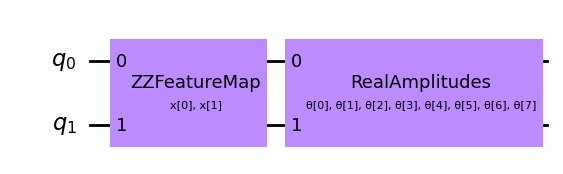

In [6]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap

qc = QuantumCircuit(num_inputs)

feature_map = ZZFeatureMap(num_inputs)
qc.compose(feature_map, inplace=True)

ansatz = RealAmplitudes(num_inputs)
qc.compose(ansatz, inplace=True)

qc.draw("mpl")

### A.2. Constructing EstimatorQNN and speciying initial weights
Now we construct the `EstimatorQNN` by passing the quantum circuit created above as an input parameter along with feature map as input and ansatz as weights.

In [7]:
from qiskit_machine_learning.neural_networks import EstimatorQNN

qnn1 = EstimatorQNN(
    circuit=qc, 
    input_params=feature_map.parameters, 
    weight_params=ansatz.parameters
)

Next we declare the initial weights randomly. If we don't explicitly declare the initial weights they are chosen uniformly at random from [-1, 1].

In [8]:
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn1.num_weights) - 1)
print("Initial weights: \n", initial_weights)

Initial weights: 
 [-0.01256962  0.06653564  0.04005302 -0.03752667  0.06645196  0.06095287
 -0.02250432 -0.04233438]


### A.3. Setting up TorchConnector using EstimatorQNN and initial weights
Finally, we set up PyTorch module using TorchConnector. We pass the EstimatorQNN and the initial weights to TorchConnector. 

In [9]:
from qiskit_machine_learning.connectors import TorchConnector

model1 = TorchConnector(qnn1, initial_weights=initial_weights)

We can test the model with a single input as follows

In [10]:
model1(X_[0, :])

tensor([-0.3285], grad_fn=<_TorchNNFunctionBackward>)

### A.4. Defining the optimizer and loss function

#### Optimizer
The choice of optimizer for training any machine learning model can be crucial in determining the success of our training's outcome. When using `TorchConnector`, we get access to all of the optimizer algorithms defined in the `torch.optim` [package](https://pytorch.org/docs/stable/optim.html). Some of the most famous algorithms used in popular machine learning architectures include **Adam**, **SGD** or **Adagrad**. However, for this tutorial we will be using the **L-BFGS algorithm** (`torch.optim.LBFGS`), one of the most well know second-order optimization algorithms for numerical optimization. 

#### Loss Function
As for the loss function, we can take advantage of PyTorch's pre-defined modules from `torch.nn`, such as the [Cross-Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) or [Mean Squared Error](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html) losses. 

Also, we set the model to training mode.

In [11]:
from torch.nn import Linear, CrossEntropyLoss, MSELoss
from torch.optim import LBFGS

optimizer = LBFGS(model1.parameters())
f_loss = MSELoss(reduction="sum")
model1.train()

TorchConnector()

**💡 Clarification:** 
In classical machine learning, the general rule of thumb is to apply a Cross-Entropy loss to classification tasks and MSE loss to regression tasks. However, this recommendation is given under the assumption that the output of the classification network is a class probability value in the [0,1] range, usually this is achieved through a Softmax layer. The following example for `EstimatorQNN` does not include such layer, and we don't apply any mapping to the output, therefore the QNN's output can take any value in the range [-1,1].

Precisely because of this, the example above uses MSELoss for classification despite it not being the norm (but we encourage you to experiment with different loss functions and see how they can impact training results).

### A.5. Training the model
LBFGS needs to reevaluate the function multiple times, so you have to pass in a closure that allows them to recompute the model. The closure should clear the gradients, compute the loss, and return it. You can explore further [here](https://pytorch.org/docs/stable/optim.html).

Also, the output will be in [-1,1] range so we use y_ with X_ for training the model.

In [12]:
print("Training ...")

def closure():
    optimizer.zero_grad()
    loss = f_loss(model1(X_) , y_) 
    loss.backward() 
    print("Loss: {:.4f}".format(loss.item()))
    return loss

optimizer.step(closure)

Training ...
Loss: 25.5356
Loss: 22.6968
Loss: 20.0392
Loss: 19.6879
Loss: 19.2672
Loss: 19.0254
Loss: 18.1547
Loss: 17.3379
Loss: 19.0828
Loss: 17.0733
Loss: 16.2185
Loss: 14.9926
Loss: 14.9293
Loss: 14.9145
Loss: 14.9076
Loss: 14.9024
Loss: 14.9021
Loss: 14.9021
Loss: 14.9021


tensor(25.5356, grad_fn=<MseLossBackward0>)

### A.6. Evaluating the model

In [13]:
y_predict = []
for x, y_target in zip(X, y):
    output = model1(Tensor(x))
    y_predict += [np.sign(output.detach().numpy())[0]]
EstimatorQNN_model_accuracy = sum(y_predict == y) / len(y)
print("Accuracy when classifying using torch connector with EstimatorQNN:", EstimatorQNN_model_accuracy)

Accuracy when classifying using torch connector with EstimatorQNN: 0.8


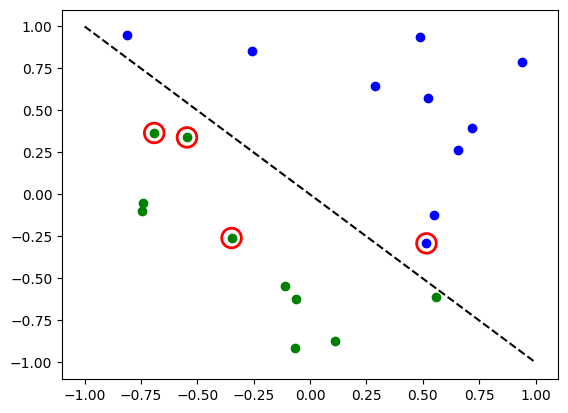

In [14]:
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In this plot,
* The <span style="color: green;">green</span> points denote Class -1
* The <span style="color: blue;">blue</span> points denote Class 1
* The <span style="color: red;">red</span> encircled points indicate wrongly classified data points.
* The dotted line separates the 2 classes

## B. Classification with PyTorch and `SamplerQNN`

Linking a `SamplerQNN` to PyTorch requires a bit more attention than `EstimatorQNN`. Without the correct setup, backpropagation is not possible. 

In particular, we must make sure that we are returning a dense array of probabilities in the network's forward pass (`sparse=False`). This parameter is set up to `False` by default, so we just have to make sure that it has not been changed.

**⚠️ Attention:** 
If we define a custom interpret function ( in the following example: `parity`), we must remember to explicitly provide the desired output shape ( in the following example: `2`). For more info on the initial parameter setup for `SamplerQNN`, please check out the [official qiskit documentation](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.neural_networks.SamplerQNN.html).

### B.1. Defining the quantum circuit using feature map and ansatz
We create a quantum circuit with the number of qubits equal to the number of features in the dataset, that is 2 in this case. Then we append the feature map and the ansatz to the circuit one after the other.

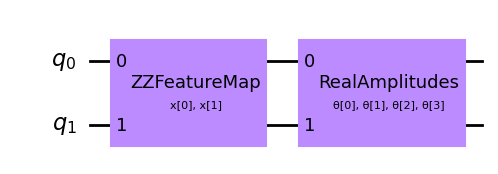

In [15]:
qc = QuantumCircuit(num_inputs)

feature_map = ZZFeatureMap(num_inputs)
qc.compose(feature_map, inplace=True)

ansatz = RealAmplitudes(num_inputs, entanglement="linear", reps=1)
qc.compose(ansatz, inplace=True)

qc.draw("mpl")

### B.2. Constructing SamplerQNN and initial setup
We start by defining the interpret fucntion as `parity`. The parity function used here returns 0 if the count of ones in a binary string is even, otherwise 1.

Note that interpret function is optional.

In [16]:
parity = lambda x: "{:b}".format(x).count("1") % 2  
print("Parity for {} is: {}".format(1100, parity(1100)))
print("Parity for {} is: {}".format(1101, parity(1101)))

Parity for 1100 is: 0
Parity for 1101 is: 1


We specify the output shape as 2, as the parity function returns either 0 or 1.

In [17]:
output_shape = 2 

Now we construct the SamplerQNN using the quantum circuit defined earlier, input from feature map, weights from ansatz, parity function as the interpreter and output shape specified as 2.

In [18]:
from qiskit_machine_learning.neural_networks import SamplerQNN

qnn2 = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

Now we initialize the starting weights randomly. If we don't explicitly declare the initial weights they are chosen uniformly at random from [-1, 1].

In [19]:
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn2.num_weights) - 1)
print("Initial weights: ", initial_weights)

Initial weights:  [ 0.0364991  -0.0720495  -0.06001836 -0.09852755]


### B.3. Defining the model using TorchConnector
Finally, we define the model using TorchConnector by providing `SamplerQNN` and initial weights as input.

In [20]:
model2 = TorchConnector(qnn2, initial_weights)

For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer). 

In [21]:
from torch.nn import CrossEntropyLoss
from torch.optim import LBFGS

optimizer = LBFGS(model2.parameters())
f_loss = CrossEntropyLoss() 
model2.train()

TorchConnector()

### B.4. Training the model
The output will be in [0,1] range so we use y01_ with X_ for training the model.

In [22]:
print("Training ...")

def closure():
    optimizer.zero_grad(set_to_none=True)
    loss = f_loss(model2(X_), y01_) 
    loss.backward()  
    print("Loss: {:.4f}".format(loss.item()))
    return loss

optimizer.step(closure);

Training ...
Loss: 0.6925
Loss: 0.6882
Loss: 0.6517
Loss: 0.6486
Loss: 0.6395
Loss: 0.7055
Loss: 0.6669
Loss: 0.6787
Loss: 0.6804
Loss: 0.6957
Loss: 0.7133
Loss: 0.7563
Loss: 0.7432
Loss: 0.6606
Loss: 0.6826
Loss: 0.6667
Loss: 0.7186
Loss: 0.7483
Loss: 0.6838
Loss: 0.7127


### B.5. Evaluating the model

In [23]:
y_predict = []
for x in X:
    output = model2(Tensor(x))
    y_predict += [np.argmax(output.detach().numpy())]
SamplerQNN_model_accuracy = sum(y_predict == y01) / len(y01)
print("Accuracy when classifying using torch connector with SamplerQNN:", SamplerQNN_model_accuracy)

Accuracy when classifying using torch connector with SamplerQNN: 0.45


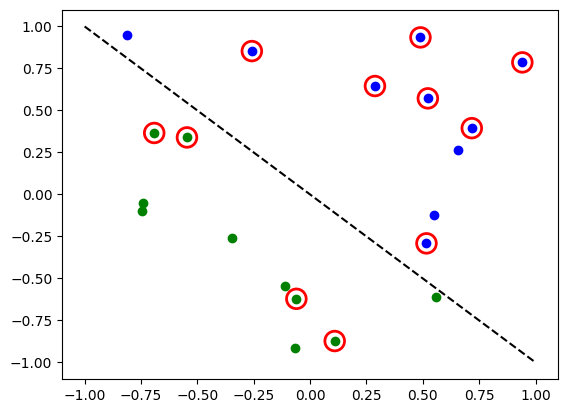

In [24]:
for x, y_target, y_ in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

In this plot,
* The <span style="color: green;">green</span> points denote Class -1
* The <span style="color: blue;">blue</span> points denote Class 1
* The <span style="color: red;">red</span> encircled points indicate wrongly classified data points.
* The dotted line separates the 2 classes

### 1.2. Comparing the models

In [25]:
print(f"Classification Model                                   | Accuracy Score")
print(f"Classification using torch connector with EstimatorQNN | {EstimatorQNN_model_accuracy:10.2f}")
print(f"Classification using torch connector  with SamplerQNN  | {SamplerQNN_model_accuracy:10.2f}")

Classification Model                                   | Accuracy Score
Classification using torch connector with EstimatorQNN |       0.80
Classification using torch connector  with SamplerQNN  |       0.45


Up until now, we have trained two models for binary classification on the dataset we generated. We pass neural networks like `EstimatorQNN` and `SamplerQNN` from `qiskit-machine-learning` to `PyTorch` using the `TorchConnector`. We find that `EstimatorQNN` performs better than `SamplerQNN` on the chosen dataset.

Now let's explore a Regression problem!

## 2. Regression 

### Regression with PyTorch and `EstimatorQNN`

We use a model based on the `EstimatorQNN` to illustrate how to perform a regression task. The chosen dataset in this case is randomly generated following a sine wave. 

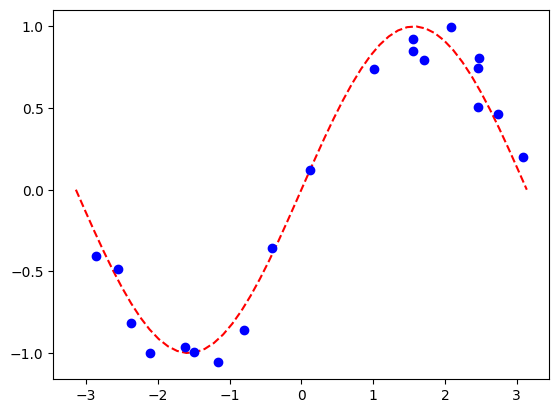

In [62]:
num_samples = 20
eps = 0.2
lb, ub = -np.pi, np.pi
f = lambda x: np.sin(x)

X = (ub - lb) * algorithm_globals.random.random([num_samples, 1]) + lb
y = f(X) + eps * (2 * algorithm_globals.random.random([num_samples, 1]) - 1)

plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")
plt.plot(X, y, "bo")
plt.show()

The network definition and training loop will be analogous to those of the classification task using `EstimatorQNN`. In this case, we define our own feature map and ansatz, but let's do it a little different.

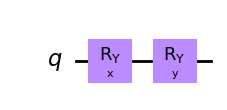

In [63]:
from qiskit.circuit import Parameter

param_x = Parameter("x")
feature_map = QuantumCircuit(1, name="fm")
feature_map.ry(param_x, 0)

param_y = Parameter("y")
ansatz = QuantumCircuit(1, name="vf")
ansatz.ry(param_y, 0)

qc = QuantumCircuit(1)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)
qc.draw('mpl')

Once the quantum circuit is ready, we construct the `EstimatorQNN` with the use of the circuit.

In [64]:
qnn3 = EstimatorQNN(
    circuit=qc, 
    input_params=[param_x], 
    weight_params=[param_y])

We set up the initial weights.If we don't explicitly declare the initial weights they are chosen uniformly at random from [-1, 1].

In [65]:
initial_weights = 0.1 * (2 * algorithm_globals.random.random(qnn3.num_weights) - 1)
print("Initial weights: ", initial_weights)

Initial weights:  [0.04308143]


Ultimately, we instantiate the model.

In [66]:
model3 = TorchConnector(qnn3, initial_weights)

Next we set the optimizer and the loss function. For a reminder on optimizer and loss function choices, you can go back to [this section](#Optimizer).

We also set the model to training mode.

In [67]:
optimizer = LBFGS(model3.parameters())
f_loss = MSELoss(reduction="sum")
model3.train()

TorchConnector()

Nothing left to construct, so we now train the model! We define the objective function in the `closure()` and run the optimizer.

In [68]:
print("Training ...")

def closure():
    optimizer.zero_grad(set_to_none=True)  
    loss = f_loss(model3(Tensor(X)), Tensor(y))  
    loss.backward()  
    print("Loss: {:.4f}".format(loss.item()))
    return loss

optimizer.step(closure)

Training ...
Loss: 25.1717
Loss: 4.4181
Loss: 1.8204
Loss: 0.2917
Loss: 0.2701
Loss: 0.2699
Loss: 0.2699


tensor(25.1717, grad_fn=<MseLossBackward0>)

Now we can evaluate the model by visualizing a plot of actual data as points and the fitted line of predictions from the regression model.

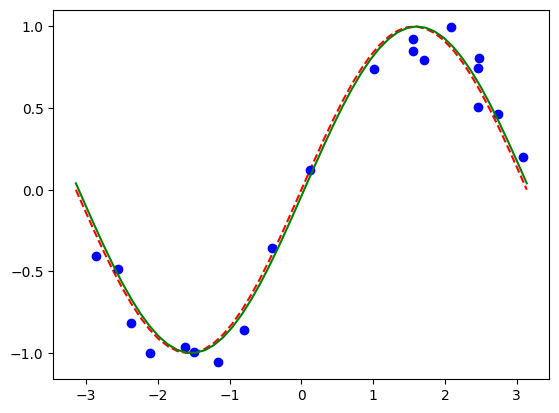

In [69]:
# Plot target function
plt.plot(np.linspace(lb, ub), f(np.linspace(lb, ub)), "r--")

# Plot data
plt.plot(X, y, "bo")
    
# Plot fitted line
y_ = []
for x in np.linspace(lb, ub):
    output = model3(Tensor([x]))
    y_ += [output.detach().numpy()[0]]
plt.plot(np.linspace(lb, ub), y_, "g-")
plt.show()

We evaluate the model in more formal terms by mathematically calculating the R2 score of the regressor.

In [72]:
from sklearn.metrics import r2_score

y_predict = []
output = model3(Tensor([X]))
y_predict += [output.detach().numpy()[0]]    
    
y_predict = Tensor(y_predict).reshape(20,)
y = y.reshape(20,)
regressor_accuracy_score = r2_score(y,y_predict)

print(f"----------------------------------------------------------------------")
print(f"Regression Model                                      | Accuracy Score")
print(f"Regression using torch connector with EstimatorQNN    | {regressor_accuracy_score:10.2f}")
print(f"----------------------------------------------------------------------")

----------------------------------------------------------------------
Regression Model                                      | Accuracy Score
Regression using torch connector with EstimatorQNN    |       0.98
----------------------------------------------------------------------


🎉🎉🎉🎉
**Woah!** 
We have covered a lot. We are capable of making hybrid models using classical models from PyTorch and connecting them with Quantum NeuralNetworks provided by qiskit-machine-learning to solve problems like classification and regression.

Let's practice what we have learned on a real dataset in Part 2 of this tutorial.

***

## Part 2: MNIST Classification, Hybrid QNNs

In this second part, we show how to leverage a hybrid quantum-classical neural network using `TorchConnector`, to perform a more complex image classification task on the MNIST handwritten digits dataset. 

For a more detailed (pre-`TorchConnector`) explanation on hybrid quantum-classical neural networks, you can check out the corresponding section in the [Qiskit Textbook](https://qiskit.org/textbook/ch-machine-learning/machine-learning-qiskit-pytorch.html).

In [35]:
# Additional torch-related imports
import torch
from torch import cat, no_grad, manual_seed
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Dropout2d,
    NLLLoss,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

### Step 1: Defining Data-loaders for train and test

We take advantage of the `torchvision` [API](https://pytorch.org/vision/stable/datasets.html) to directly load a subset of the [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database) and define torch `DataLoader`s ([link](https://pytorch.org/docs/stable/data.html)) for train and test.

In [36]:
# Train Dataset
# -------------

# Set train shuffle seed (for reproducibility)
manual_seed(42)

batch_size = 1
n_samples = 100  # We will concentrate on the first 100 samples

# Use pre-defined torchvision function to load MNIST train data
X_train = datasets.MNIST(
    root="./data", train=True, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_train.targets == 0)[0][:n_samples], np.where(X_train.targets == 1)[0][:n_samples]
)
X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

# Define torch dataloader with filtered data
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

If we perform a quick visualization we can see that the train dataset consists of images of handwritten 0s and 1s.

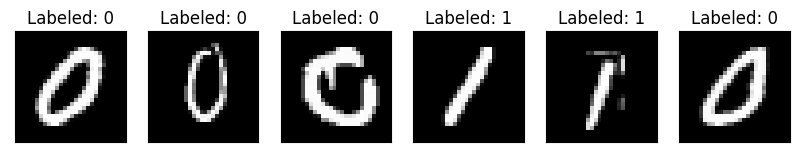

In [37]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0, 0].numpy().squeeze(), cmap="gray")
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets[0].item()))

    n_samples_show -= 1

In [38]:
# Test Dataset
# -------------

# Set test shuffle seed (for reproducibility)
# manual_seed(5)

n_samples = 50

# Use pre-defined torchvision function to load MNIST test data
X_test = datasets.MNIST(
    root="./data", train=False, download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# Filter out labels (originally 0-9), leaving only labels 0 and 1
idx = np.append(
    np.where(X_test.targets == 0)[0][:n_samples], np.where(X_test.targets == 1)[0][:n_samples]
)
X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

# Define torch dataloader with filtered data
test_loader = DataLoader(X_test, batch_size=batch_size, shuffle=True)

### Step 2: Defining the QNN and Hybrid Model

This second step shows the power of the `TorchConnector`. After defining our quantum neural network layer (in this case, a `EstimatorQNN`), we can embed it into a layer in our torch `Module` by initializing a torch connector as `TorchConnector(qnn)`.

**⚠️ Attention:**
In order to have an adequate gradient backpropagation in hybrid models,  we MUST set the initial parameter `input_gradients` to TRUE during the qnn initialization.

In [39]:
# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(2)
    ansatz = RealAmplitudes(2, reps=1)
    qc = QuantumCircuit(2)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = EstimatorQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    return qnn


qnn4 = create_qnn()

In [40]:
# Define torch NN module


class Net(Module):
    def __init__(self, qnn):
        super().__init__()
        self.conv1 = Conv2d(1, 2, kernel_size=5)
        self.conv2 = Conv2d(2, 16, kernel_size=5)
        self.dropout = Dropout2d()
        self.fc1 = Linear(256, 64)
        self.fc2 = Linear(64, 2)  # 2-dimensional input to QNN
        self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen
        # uniformly at random from interval [-1,1].
        self.fc3 = Linear(1, 1)  # 1-dimensional output from QNN

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.qnn(x)  # apply QNN
        x = self.fc3(x)
        return cat((x, 1 - x), -1)


model4 = Net(qnn4)

inline comments and links

### Step 3: Training

In [41]:
# Define model, optimizer, and loss function
optimizer = optim.Adam(model4.parameters(), lr=0.001)
loss_func = NLLLoss()

# Start training
epochs = 10  # Set number of epochs
loss_list = []  # Store loss history
model4.train()  # Set model to training mode

for epoch in range(epochs):
    total_loss = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad(set_to_none=True)  # Initialize gradient
        output = model4(data)  # Forward pass
        loss = loss_func(output, target)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        total_loss.append(loss.item())  # Store loss
    loss_list.append(sum(total_loss) / len(total_loss))
    print("Training [{:.0f}%]\tLoss: {:.4f}".format(100.0 * (epoch + 1) / epochs, loss_list[-1]))

Training [10%]	Loss: -1.1630
Training [20%]	Loss: -1.5294
Training [30%]	Loss: -1.7855
Training [40%]	Loss: -1.9863
Training [50%]	Loss: -2.2257
Training [60%]	Loss: -2.4513
Training [70%]	Loss: -2.6758
Training [80%]	Loss: -2.8832
Training [90%]	Loss: -3.1006
Training [100%]	Loss: -3.3061


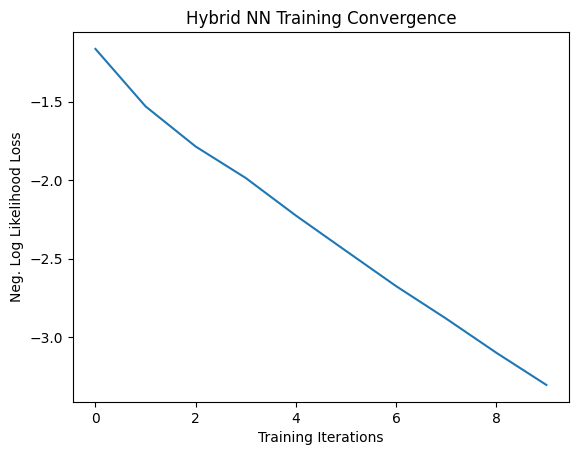

In [42]:
# Plot loss convergence
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Neg. Log Likelihood Loss")
plt.show()

Now we'll save the trained model, just to show how a hybrid model can be saved and re-used later for inference. To save and load hybrid models, when using the TorchConnector, follow the PyTorch recommendations of saving and loading the models.

In [43]:
torch.save(model4.state_dict(), "model4.pt")

### Step 4: Evaluation

We start from recreating the model and loading the state from the previously saved file. You create a QNN layer using another simulator or a real hardware. So, you can train a model on real hardware available on the cloud and then for inference use a simulator or vice verse. For a sake of simplicity we create a new quantum neural network in the same way as above.

In [44]:
qnn5 = create_qnn()
model5 = Net(qnn5)
model5.load_state_dict(torch.load("model4.pt"))

<All keys matched successfully>

In [45]:
model5.eval()  # set model to evaluation mode
with no_grad():

    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        output = model5(data)
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()

        loss = loss_func(output, target)
        total_loss.append(loss.item())

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), correct / len(test_loader) / batch_size * 100
        )
    )

Performance on test data:
	Loss: -3.3585
	Accuracy: 100.0%


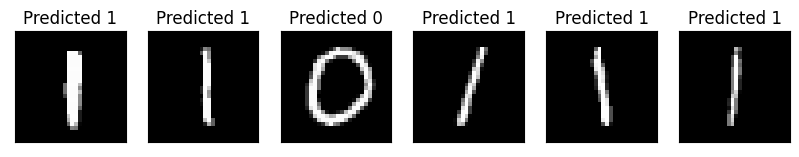

In [46]:
# Plot predicted labels

n_samples_show = 6
count = 0
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

model5.eval()
with no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        if count == n_samples_show:
            break
        output = model5(data[0:1])
        if len(output.shape) == 1:
            output = output.reshape(1, *output.shape)

        pred = output.argmax(dim=1, keepdim=True)

        axes[count].imshow(data[0].numpy().squeeze(), cmap="gray")

        axes[count].set_xticks([])
        axes[count].set_yticks([])
        axes[count].set_title("Predicted {}".format(pred.item()))

        count += 1

🎉🎉🎉🎉
**You are now able to experiment with your own hybrid datasets and architectures using Qiskit Machine Learning.** 
**Good Luck!**

We have learned how to use Qiskit's TorchConnector class with NeuralNetwork from Qiskit Machine Learning into a PyTorch workflow. We used this hybrid approach to first implement a solution to classification and regression problem on a small self generated dataset. We further dived into a real world example by solving MNIST number classification using the hybrid machine learning model comprising of quantum and classical.



In [47]:
import qiskit.tools.jupyter

%qiskit_version_table
%qiskit_copyright